# Klasterovanje teksta u skupu podataka zaposlenih u programerskim firmama


# Uvod <a class="anchor" id="intro"></a>
<hr />

Moj zadatak se sastojao iz toga da primenim algoritme klasterovanja koji su se radili na 
časovima kursa Istraživanje Podataka, i da na osnovu njih zaključim neke zaključke iz skupa podataka *employee_reviews*. U daljem tekstu ćemo proći kroz faze preprocesiranja, ukidanja *"nebitnih"* kolona, i primene algoritama za klasterovanje, kao što su *K-Sredina*, *DBSCAN* i *Hierarhijsko klasterovanje*. Dotaći ćemo se i ocena klasterovanja i zaključivanja optimalnog broja klastera za zadate algoritme(*koeficijent senke* i metoda *lakta*) Nakon toga, ćemo prikazati podatke i izneti bitne zaključke za zadati skup. Kao zadatu alatku za seminarski rad sam odabrao *Jupyter* svesku i jezik *Python*. Odabrao sam ovo okruženje jer mi se činilo jako zanimljivim za korišćenje i omogućavao je jednostavnije prebacivanje iz *.ipynb* formata u *pdf*, koji bi takođe imao i priložen korišćen kod. Sam jezik Python je takođe uticao na izbor ovog okruženja, zbog jednostavnosti pisanja koda i ogromnog broja modula za istraživanje skupa podataka.


In [212]:
#osnovni moduli za korišćenje

from sklearn.cluster import KMeans

import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##  Skup podataka *employee_reviews* <a class="anchor" id="df"></a>

Naš skup podataka je preuzet sa <a href="https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews">linka</a>. Skup podataka se sastoji od zaposlenih ljudi(bivših i sadašnjih) i njihovih recenzija i ocena radnog mesta. 

In [213]:
df = pd.read_csv('./employee_reviews.csv')
df.head(5) #razlog komentarisanja je jako los ispis 

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


## Osnovna svojstva <a class='anchor' id='features'></a>
Kao što se može videti iz priliženog, radi se o poprilično velikom skupu podataka(67529 kolona i 17 atributa). Isto tako, iz priloženih podataka dole, možemo videti o kakvim tipovima je reč. Takođe, da određeni atributi imaju *null* vrednosti("summary" i "advice-to-mgmt"). Daljim pregledom našeg skupa podataka smo naišli na *"none"* vrednosti, koje samo pokazuju da korisnici kad su unosili recenzije o zadatoj firmi su izostavili neke stvari, koje su verovatno smatrali neobaveznim za unošenje. Na nama je da odlučimo kako ćemo ukloniti takve vrednosti, dva poznata načina su: uklanjanje svih redova u kojima se pojavljuju neke od tih *neželjenih* vrednosti ili postavljanje tih nepostojećih na neku podrazumevanu vrednost. Možda uklanjanje svih tih *neželjenih* vrednosti, za primer našeg skupa uzećemo tu vrednost *"none"*, možda i nije toliko dobar pristup(ranijim testiranjem se ispostavilo da ukloni više od 2/3 redova), jer možda gubimo bitne informacije u nekim drugim atributima koje su nam bitni za dalju analizu. Resenje koje bi možda bilo pametnije da je uklonimo samo za nama bitne kolone.

In [214]:
#veličina našeg skupa
df.shape

(67529, 17)

In [215]:
#osnovna svojstva kao što su tipovi atributa i neke statističke ocene
print("Info: ", df.info())
print("Osnovna: ", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67529 entries, 0 to 67528
Data columns (total 17 columns):
Unnamed: 0                    67529 non-null int64
company                       67529 non-null object
location                      67529 non-null object
dates                         67529 non-null object
job-title                     67529 non-null object
summary                       67409 non-null object
pros                          67529 non-null object
cons                          67529 non-null object
advice-to-mgmt                67232 non-null object
overall-ratings               67529 non-null float64
work-balance-stars            67529 non-null object
culture-values-stars          67529 non-null object
carrer-opportunities-stars    67529 non-null object
comp-benefit-stars            67529 non-null object
senior-mangemnet-stars        67529 non-null object
helpful-count                 67529 non-null int64
link                          67529 non-null object
dtypes: 

In [216]:
#brojimo null vrednosti da znamo da ih uklonimo
df.isnull().sum()

Unnamed: 0                      0
company                         0
location                        0
dates                           0
job-title                       0
summary                       120
pros                            0
cons                            0
advice-to-mgmt                297
overall-ratings                 0
work-balance-stars              0
culture-values-stars            0
carrer-opportunities-stars      0
comp-benefit-stars              0
senior-mangemnet-stars          0
helpful-count                   0
link                            0
dtype: int64

In [217]:
#izvlacimo svojstva, koja ce nam verovatno biti potrebna
features = df.columns
features

Index(['Unnamed: 0', 'company', 'location', 'dates', 'job-title', 'summary',
       'pros', 'cons', 'advice-to-mgmt', 'overall-ratings',
       'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars', 'helpful-count', 'link'],
      dtype='object')

Kao što smo gore naveli, *"none"* vrednost je verovatno neka podrazumevana vrednost za prazno polje, tako da je možda bolje čak i ne uklanjati u svim atributima, sem u nekim bitnijim atributima.

In [218]:
# iz ovog vidimo da ako uklonimo sve none vrednosti koje imamo, 
# mozemo da izgubimo dosta podataka
for feature in features:
    print("feature name: %s | count `none` values: %d" 
          %(feature, df[df[feature] == 'none'].shape[0]))

feature name: Unnamed: 0 | count `none` values: 0
feature name: company | count `none` values: 0
feature name: location | count `none` values: 25085
feature name: dates | count `none` values: 0
feature name: job-title | count `none` values: 0
feature name: summary | count `none` values: 9
feature name: pros | count `none` values: 0
feature name: cons | count `none` values: 1
feature name: advice-to-mgmt | count `none` values: 29164
feature name: overall-ratings | count `none` values: 0
feature name: work-balance-stars | count `none` values: 7160
feature name: culture-values-stars | count `none` values: 13546
feature name: carrer-opportunities-stars | count `none` values: 7108
feature name: comp-benefit-stars | count `none` values: 7161
feature name: senior-mangemnet-stars | count `none` values: 7775
feature name: helpful-count | count `none` values: 0
feature name: link | count `none` values: 0


/usr/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Ovde već vidimo da je jedan od kategoričkih atributa za koje sam mislio da 
će nam biti korisniji za dalju analizu, *advice-to-mgmt*, jako loš, budući da dosta zaposlenih nije htelo da napiše neki tekst u tom polju. Uklanjanjem none vrednosti na osnovu tog atributa bi dovelo do brisanja oko 30000 redova, što je već pola skupa. Pored toga, bez obzira što nisam razmatrao o njoj, kolona *location* ima isto 25085 *"none"* polja, i primena klasterovanja ovde se isto ne isplati(doduše ne bi se isplatila jer je početni zadatak bio klasterovanje teksta, a ne reči).

In [219]:
#da iskopamo te srecnike koji nemaju konstruktivne kritike uopste :D
df[df["cons"] == 'none']

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
42755,42756,apple,"Charlotte, NC","Jul 27, 2015",Current Employee - Anonymous Employee,a great place,everything is awesome!!,none,none,4.0,5.0,5.0,5.0,5.0,5.0,0,https://www.glassdoor.com/Reviews/Apple-Review...


## Preprocesiranje. Istraživačka analiza podataka - EDA. <a class="anchor" id="preproc"></a>

Možda nas zanima koliko je recenzija za svaku firmu postavljeno, čisto da znamo kojih ima najviše, a kojih najmanje.

In [220]:
#cisto radi vezbe i zabave, grupisacemo da vidimo koliko ima zaposlenih u kojoj firmi
group_by_company = df.groupby('company').size()
group_by_company

company
amazon       26430
apple        12950
facebook      1590
google        7819
microsoft    17930
netflix        810
dtype: int64

Kao što vidimo, najviše recenzija ima za *Amazon* i *Microsoft*, dok najmanje za *Netflix* i *Facebook*. 
Takodje pošto smo prilikom gledanja našeg skupa zaposlenih uvideli da postoje sadašnji i bivši zaposleni, možda ne bi bilo loše da odnos bivših i sadašnjih radnika prikažemo.

current    42539
former     24990
Name: job-title, dtype: int64


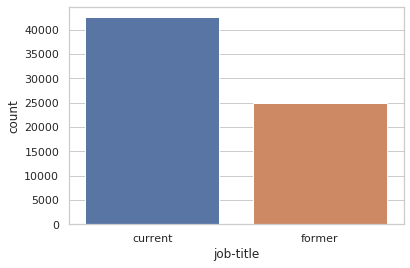

In [221]:
#isto tako smo mogli da grupisemo po poslu
group_by_job_title = df.groupby('job-title').size()
#odavde me zanima recimo koliko ima trenutnih, koliko ima bivsih zaposlenih
employee_ratio = df['job-title']
current_former = employee_ratio.map(lambda x : 'former' if 'Former' in x else 'current')
print(current_former.value_counts())
sns.countplot(current_former)
plt.show()

In [222]:
#i po lokaciji
group_by_location = df.groupby('location').size()

In [223]:
#a i po datumu
group_by_date = df.groupby('dates').size()
max_date = max(group_by_date.values)
maybe_important_date = list(filter(lambda x : x[1] == max_date, list(group_by_date.items())))
maybe_important_date_name = maybe_important_date[0][0]
maybe_important_date_date = maybe_important_date[0][1]
print("dan kad je najvise komentara okaceno %s : %s\n" 
       % (str(maybe_important_date_name), maybe_important_date_date))
#iz ovoga vidimo da je na taj dan najvise napisano izvestaja o amazonu
df[df['dates'] == maybe_important_date_name].groupby('company').size()

dan kad je najvise komentara okaceno  Sep 19, 2017 : 272



company
amazon       251
apple          5
google         6
microsoft      9
netflix        1
dtype: int64

Procenat podataka na osnovu kompanije će nam reći zastupljenost recenzija za svaku datu kompaniju
u našem skupu podataka. Ovaj podatak možemo iskoristiti da one manje zastupljene(kad smo ih
gore prebrojavali, videli smo da se radi o *Facebooku* i *Netflixu*) izbacimo.

In [224]:
#preprocesiranje podataka
#procenat podataka na osnovu kompanije
df["company"].value_counts()/len(df["company"])*100

amazon       39.138740
microsoft    26.551556
apple        19.176946
google       11.578729
facebook      2.354544
netflix       1.199485
Name: company, dtype: float64

In [225]:
df = df.drop(['Unnamed: 0', 'link'], axis=1)
df = df.loc[~df['company'].isin(['facebook', 'netflix']), :]
df = df.loc[df['dates'] != 'none', :]
df['year'] = pd.to_datetime(df['dates'], errors='coerce').dt.year
df.dropna(how='all', inplace=True)
df.dropna(subset=['company', 'summary', 'year', "overall-ratings", "job-title", "advice-to-mgmt"], inplace=True)
df['year'] = df['year'].astype('int64')
df.head()



,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,year
0,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,2018
1,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,2013
2,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,2014
3,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,2015
4,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,2018


In [226]:
df.shape

(64743, 16)

In [227]:
df.groupby('company')['overall-ratings'].describe()

,count,mean,std,min,25%,50%,75%,max
company,,,,,,,,
amazon,26281.0,3.585100,1.257579,1.0,3.0,4.0,5.0,5.0
apple,12857.0,3.958000,1.063601,1.0,3.0,4.0,5.0,5.0
google,7775.0,4.338907,0.920843,1.0,4.0,5.0,5.0,5.0
microsoft,17830.0,3.815143,1.036999,1.0,3.0,4.0,5.0,5.0


##### Broj recenzija za svaku kompaniju <a class="anchor" id="eda1"></a>


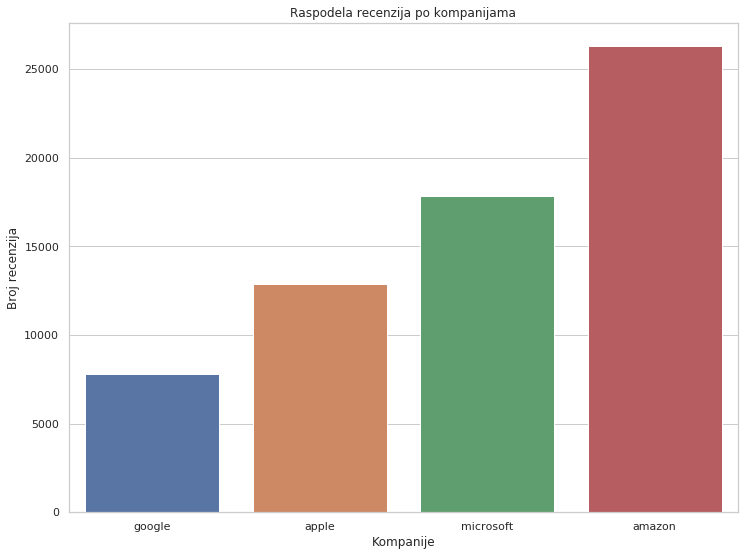

In [228]:
rw_count = df['company'].value_counts().sort_values(ascending=True)
cmp_labels = rw_count.index.tolist()
cmp_index = np.arange(len(cmp_labels))
sns.set(style='whitegrid')
plt.figure(figsize=(12,9))
sns.barplot(cmp_index, rw_count)
plt.xticks(cmp_index, cmp_labels)
plt.xlabel('Kompanije')
plt.ylabel('Broj recenzija')
plt.title('Raspodela recenzija po kompanijama')
plt.show()

Zaključak koji izvlačimo iz ovoga je da Amazon ima najviše recenzija, dok Google najmanje.

#### Broj recenzija po godinama <a class="anchor" id="eda2"></a>

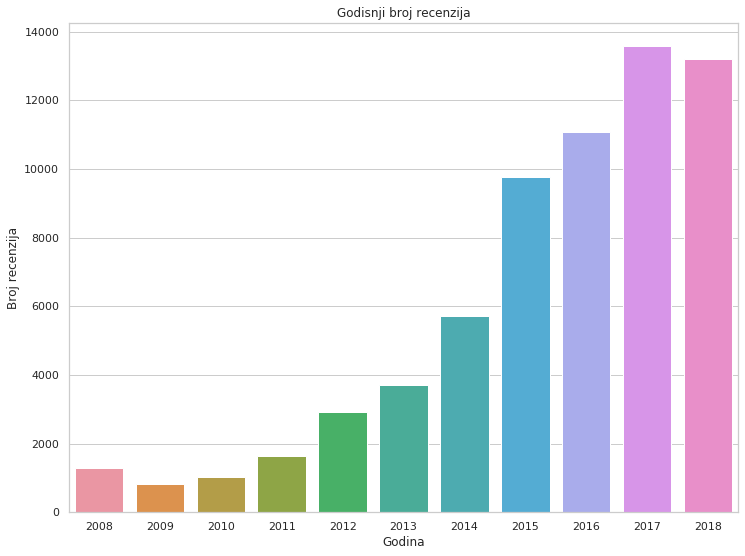

In [229]:
yr_count = df['year'].value_counts().sort_index(ascending=True)
yr_labels = yr_count.index.tolist()
yr_index = np.arange(len(yr_labels))

#vecina recenzija je napisana u prethodnih 3-4 godine
plt.figure(figsize=(12,9))
sns.barplot(yr_index, yr_count)
plt.xticks(yr_index, yr_labels)
plt.xlabel('Godina')
plt.ylabel('Broj recenzija')
plt.title('Godisnji broj recenzija')
plt.show()

Zaključak koji izvlačimo ovde je da u poslednjih četiri ili pet godina najviše recenzija napisano(potencijalno možemo da eliminišemo recenzije iz godina 2008-2013, ali pre toga moramo da proverimo da li se iz godišnjeg broja recenzija po firmama može izvesti isti zaključak).

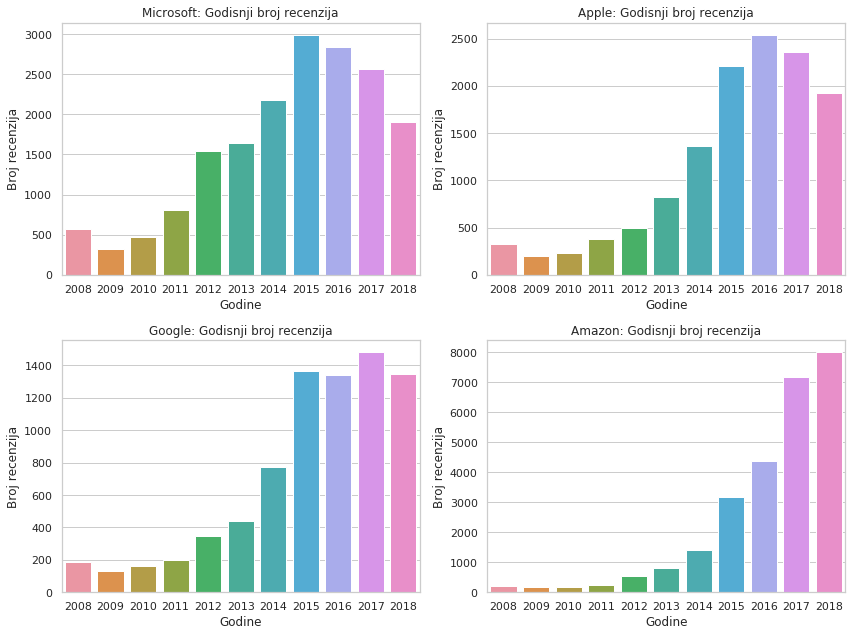

In [230]:
fig, axs = plt.subplots(2,2,figsize=(12,9))
companies = [['microsoft', 'apple'], ['google', 'amazon']]

for i in range(2):
    for j in range(2):
        company = companies[i][j]
        yr_count = df[df['company'] == company]['year'].value_counts().sort_index(ascending=True)
        yr_labels = yr_count.index.tolist()
        yr_index = np.arange(len(yr_labels))
        g = sns.barplot(yr_index, yr_count, tick_label = yr_labels, ax=axs[i][j])
        g.set(xticklabels=yr_labels)
        axs[i][j].set_xlabel('Godine')
        axs[i][j].set_ylabel('Broj recenzija')
        axs[i][j].set_title("%s: Godisnji broj recenzija" % (company.title()))
plt.tight_layout()

Zaključak koji izvlačimo ovde je da je najvise recenzija bilo u poslednjih četiri-pet godina.

In [231]:
df = df[df['year'].isin(["2018", "2017", "2016", "2015"])]

##### Prikaz promene prosečne ocene kompanije od 2015. do 2018. godine <a class="anchor" id="eda3"></a>

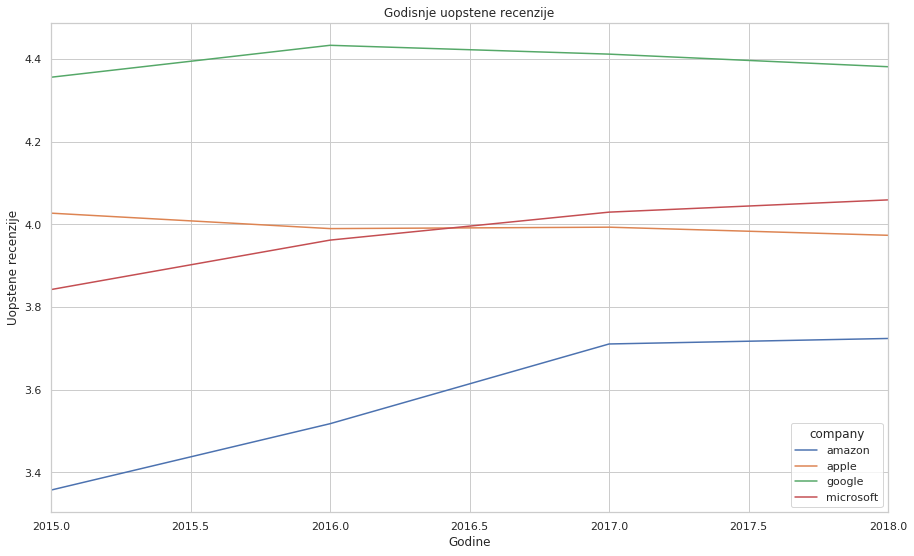

In [232]:
fig, ax = plt.subplots(figsize=(15,9))
df.groupby(['year', 'company'])['overall-ratings'].mean().unstack().plot(ax=ax)
plt.xlabel("Godine")
plt.ylabel("Uopstene recenzije")
plt.title("Godisnje uopstene recenzije")
plt.show()

Možemo primetiti da u svakoj kompaniji, sem u *Apple-u*, posle 2015. raste prosečna ocena

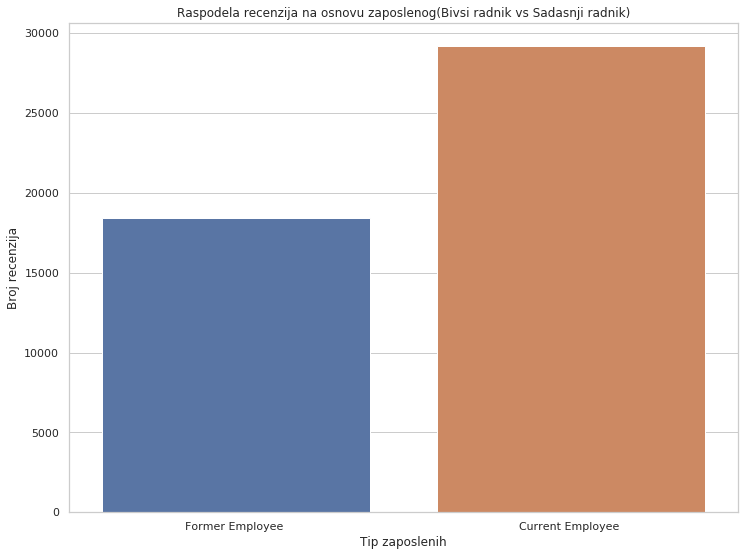

In [233]:
current_employee_count = df['job-title'].str.split('-', expand=True)[0].value_counts().sort_values(ascending=True)
employee_labels = current_employee_count.index.tolist()
employee_index = np.arange(len(employee_labels))


plt.figure(figsize=(12, 9))
sns.barplot(employee_index, current_employee_count)
plt.xticks(employee_index, employee_labels)

plt.xlabel('Tip zaposlenih')
plt.ylabel('Broj recenzija')
plt.title('Raspodela recenzija na osnovu zaposlenog(Bivsi radnik vs Sadasnji radnik)')
plt.show()

##### Prosečna ocena svih kompanija za svaki kriterijum <a class="anchor" id="eda4"></a>

In [234]:
ratings_comp = df[["company", "work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]]
ratings_comp.set_index(["company"], inplace=True)
ratings_comp = ratings_comp[~(ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] == "none").any(axis=1)]
ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] = ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].apply(pd.to_numeric)
group = ratings_comp.groupby("company")["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()
group.columns = ["Work Balance", "Culture Values", "Career Opportunities", "Company Benefits", "Senior Management"]
group = group.transpose()
group

company,amazon,apple,google,microsoft
Work Balance,3.058085,3.353150,4.026710,3.647677
Culture Values,3.555482,4.104449,4.352752,3.780830
Career Opportunities,3.642456,3.461402,4.081050,3.752911
Company Benefits,3.729022,4.112435,4.450610,4.053804
Senior Management,3.193497,3.465839,3.886254,3.345993


In [235]:
def rating_per_company(rating_type, title, color):
    work_ratings = df[['company', rating_type]]
    work_ratings = work_ratings[~(work_ratings[[rating_type]] == "none").any(axis=1)]
    work_ratings[rating_type] = work_ratings[rating_type].apply(pd.to_numeric)
    group = work_ratings.groupby(work_ratings["company"].str.title())[rating_type].mean().reset_index()
    group.sort_values([rating_type],inplace=True)
    group.set_index('company').plot.barh(legend=False, figsize=(12, 10), color=color)
    plt.title('{} Rating'.format(title))
    plt.xlabel('Rating')
    plt.ylabel('Companies')

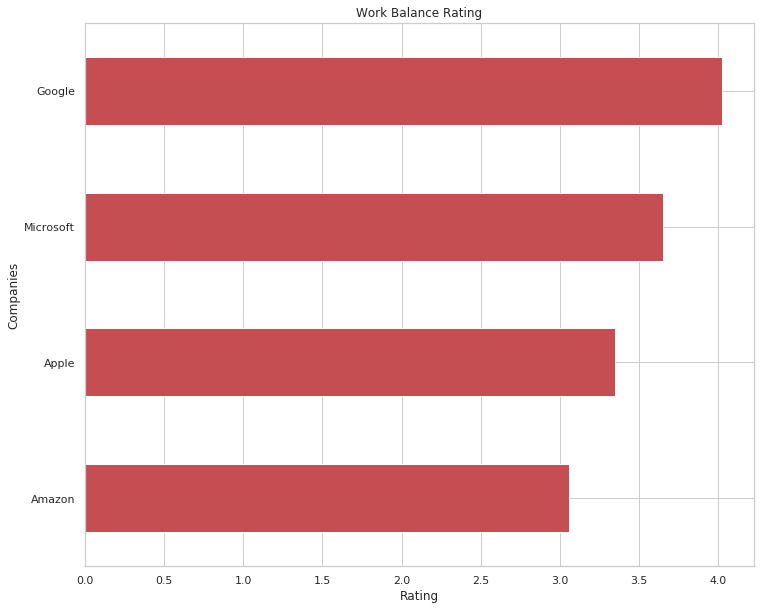

In [236]:
rating_per_company('work-balance-stars', "Work Balance", "r")

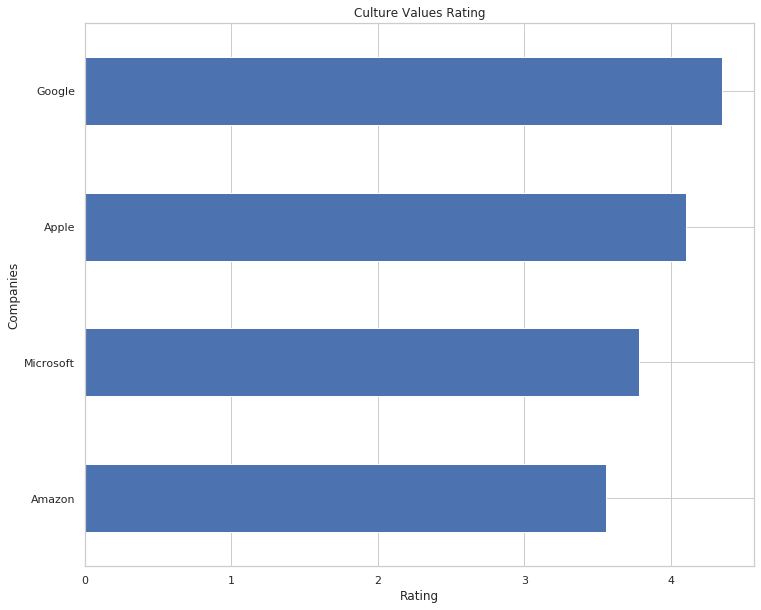

In [237]:
rating_per_company("culture-values-stars", "Culture Values", "b")

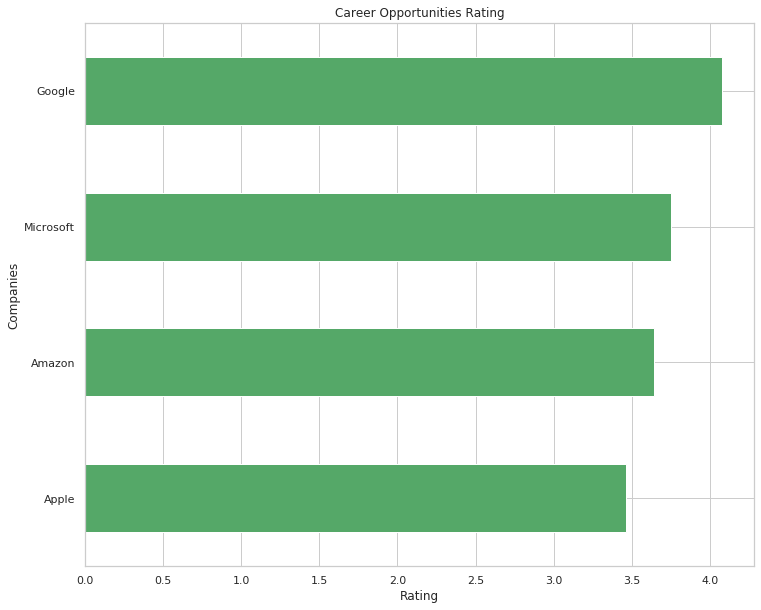

In [238]:
rating_per_company("carrer-opportunities-stars", "Career Opportunities", "g")

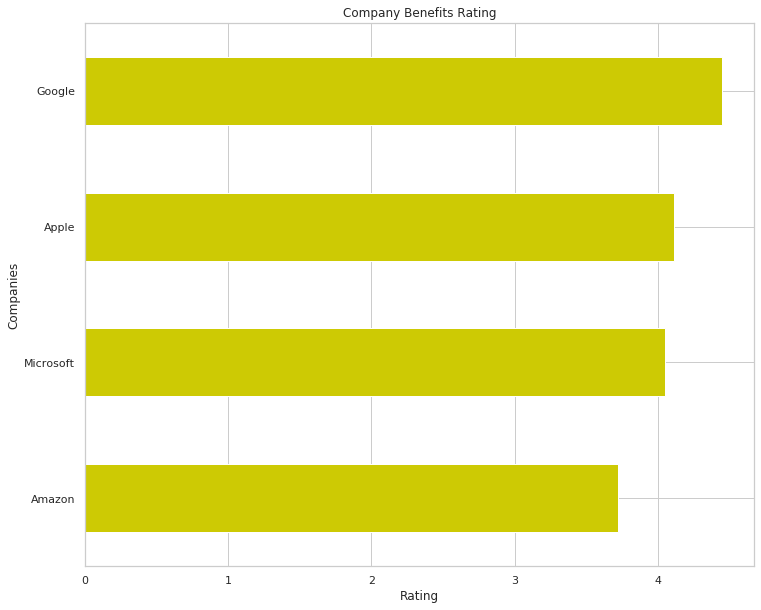

In [239]:
rating_per_company("comp-benefit-stars", "Company Benefits", "#cdca04")

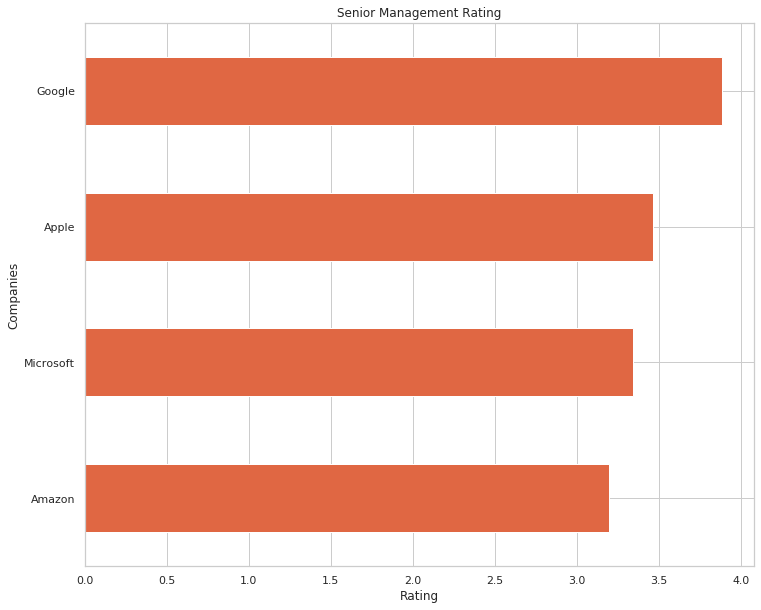

In [240]:
rating_per_company("senior-mangemnet-stars", "Senior Management", "#e06743")

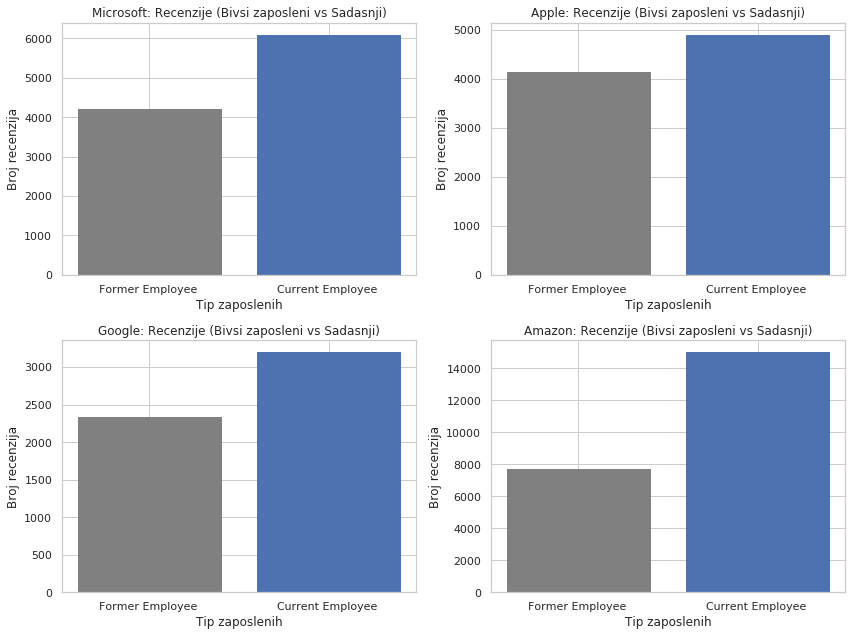

In [241]:
fig, axs = plt.subplots(2,2, figsize=(12, 9), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()


for i, company in enumerate(companies):
    current_employee_count = df.loc[df['company'] == company]['job-title'].str.split('-', expand=True)[0].value_counts().sort_values(ascending=True)
    employee_labels = current_employee_count.index.tolist()
    employee_index = np.arange(len(employee_labels))
        
    bars = axs[i].bar(employee_index, current_employee_count, tick_label=employee_labels)
    bars[0].set_color('gray')
    bars[1].set_color('b')
    axs[i].set_xlabel('Tip zaposlenih')
    axs[i].set_ylabel('Broj recenzija')
    axs[i].set_title('%s: Recenzije (Bivsi zaposleni vs Sadasnji)' %(company.title()))
    
fig.tight_layout()

Zaključak je da najviše napisanih recenzija za svaku kompaniju dolazi od trenutno zaposlenih ljudi.

In [242]:
df['job-title'].str.split(' - ', expand=True)[1].value_counts().head(5)

Anonymous Employee               21779
Software Engineer                  928
Specialist                         647
Software Development Engineer      613
Warehouse Associate                583
Name: 1, dtype: int64

#### Prosečna ocena za kompaniju na osnovu bivšeg i sadašnjeg zaposlenog <a class="anchor" id="eda5"></a>

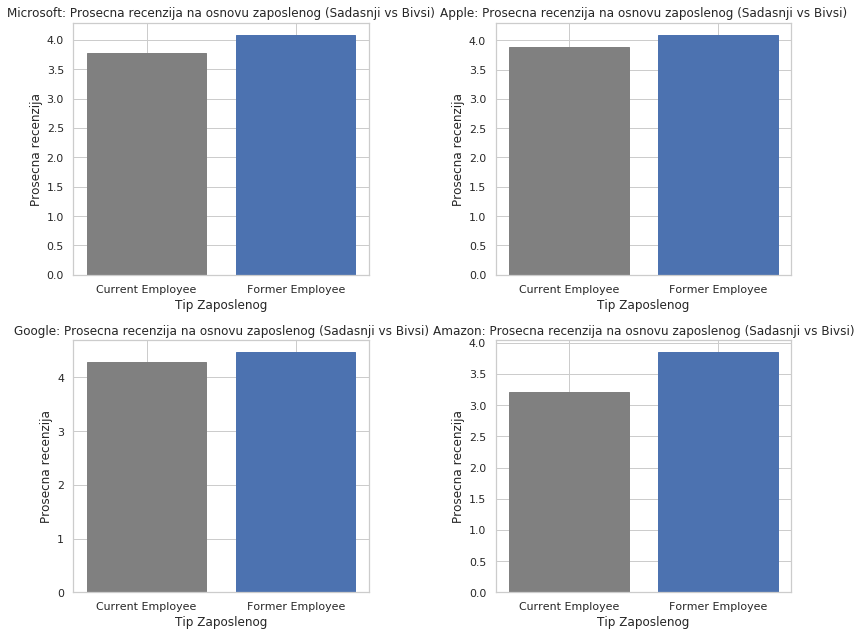

In [243]:
fig, axs = plt.subplots(2,2, figsize=(12, 9), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()

for i, company in enumerate(companies):
    
        job_rating = df[df['company'] == company][['job-title', 'overall-ratings']]
        job_rating['job-title'] = job_rating['job-title'].str.split(' - ', expand=True)[0]
        job_rating_count = job_rating.groupby('job-title')['overall-ratings'].mean().sort_values(ascending=True)

        bars = axs[i].bar([0,1], job_rating_count, tick_label = ['Current Employee', 'Former Employee'])
        bars[0].set_color('gray')
        bars[1].set_color('b')
        axs[i].set_title('{}: Prosecna recenzija na osnovu zaposlenog (Sadasnji vs Bivsi)'.format(company.title()))
        axs[i].set_xlabel("Tip Zaposlenog")
        axs[i].set_ylabel("Prosecna recenzija")

fig.tight_layout()

Zaključak je da *Amazon* ima najveću razliku u prosečnoj ocenu koje su dali bivši i sadašnji zaposleni.

## Izbor korisnijih kolona za dalju analizu <a class="anchor" id="preproc1"></a>
<hr />

Od svih kolona, deluje mi da su nam samo *summary*, *pros*, *cons*, *overall-ratings* korisnije, jer iz njih možemo tekst da izvučemo da bi sproveli dalju analizu, dok prosečnu ocenu možemo da pretvorimo u kategorički atribut. Daljom analizom *summary* kolone, može se videti da je većina tih sažetaka jako kratka i da sadrži ili par reči ili poziciju zaposlenog. 

In [244]:
new_df = df.iloc[:,[0,4,5,6,8]]
new_df.head()

,company,summary,pros,cons,overall-ratings
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,5.0
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,5.0
4,google,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",5.0
5,google,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,5.0
6,google,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,5.0


In [245]:
review = new_df['overall-ratings']
ctgr = review.map(lambda x : 'positive' if x > 3 else 'negative')
new_df['overall-ratings'] = ctgr
new_df.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,company,summary,pros,cons,overall-ratings
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,positive
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,positive
4,google,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",positive
5,google,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,positive
6,google,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,positive


In [246]:

new_df['overall-ratings'].value_counts()

positive    32850
negative    14749
Name: overall-ratings, dtype: int64

# Klasterovanje <a class="anchor" id="clust1"></a>
<hr />

Klasterovanje ili klaster analiza je pronalaženje grupa objekata takvih da su objekti u grupi međusobno slični, odnosno da su objekti u različitim grupama međusobno različiti.



## Klasterovanje teksta <a class="anchor" id="clust2"></a>
<hr />

Pošto računari razumeju samo brojeve, tekst je potrebno pretvoriti u brojeve.
Klasterovanje teksta ima primenu u automatskoj organizaciji dokumenata(tekstova), izvlačenju tema ili brzih informacija. Svodi se na korišćenje *deskriptora*, koji su skupovi reči koji opisuju sadržaj klastera. Cilj klasterovanja
teksta je da grupiše tekstove u razdvojene skupove klastera.

Postupak prilikom klasterovanja teksta
* tokenizacija
* okrnjavanje(*eng. stemming*)
* uklanjanje zaustavnih reči i znakova interpukcije
* računanje učestalosti termova svih tokena(*CountVectorizer, TF-IDF, Word2Vec*)
* klasterovanje
* ocenjivanje i grafički prikaz

Da bi mogli da sprovedemo klasterovanje teksta, koristimo NLTK. On je skup alatki za obradu prirodnih jezika(NLP), koji u svojem sastavu ima i zaustavne reči(*eng. - stopwords*) i alat koji svodi na koren reči(ne nužno morfološki koren). Takođe nije samo razvijen da obrađuje engleski jezik, već može i ostale. Pored ovih, omogućava i druge obrade, vezane za semantičko značenje, označavanje, parsiranje.

In [247]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sno = nltk.stem.SnowballStemmer('english')
stop = set(stopwords.words('english'))

def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#|<|>]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

#print(stop)
#print(sno.stem("tasting"))

[nltk_data] Downloading package stopwords to /home/vumpus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [248]:
i=0
stringic=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in new_df['pros'].values:
    filtered_sentence=[]
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (new_df['overall-ratings'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(new_df['overall-ratings'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    stringic = b" ".join(filtered_sentence) 
    
    final_string.append(stringic)
    i+=1


In [249]:
new_df['CleanedText'] = final_string
new_df['CleanedText'] = new_df['CleanedText'].str.decode('utf-8')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Brojači reči

### *CountVectorizer*
<hr />

CountVectorizer koristi princip "*džak reči*", što znači da se svaka reč u svakom tekstu broji i predstavlja kao matrica.

In [250]:
from sklearn.feature_extraction.text import CountVectorizer
c_vect = CountVectorizer()
bow = c_vect.fit_transform(new_df['CleanedText'].values)
bow.shape

(47599, 10180)

In [251]:
terms = c_vect.get_feature_names()
terms[:20]

['aa',
 'aaa',
 'aaaaaamaz',
 'aan',
 'aand',
 'aandacht',
 'aandelen',
 'aapl',
 'aar',
 'ab',
 'aba',
 'abandon',
 'abd',
 'aber',
 'abgefeiert',
 'abid',
 'abidjan',
 'abil',
 'abiliy',
 'abl']

#### "Lakat" metoda

"Lakat" metoda se koristi u klaster analizi za otkrivanje optimalnog broja klastera za zadati skup podataka. Nekad nije dobro osloniti(jer je višeznačna i ona će odrediti optimalan broj klastera za naš raspon, ali je pitanje da li je raspon broja klastera koji smo uzeli u obzir dobar) se na nju i da je bolje koristiti koeficijent Senke(*eng. Silhouette coefficient*). Za svako k računamo unutrašnju sumu kvadrata klastera(WSS), i iscrtavamo krivu za to zadato k. Mesto gde se nalazi "lakat" se uzima kao optimalan broj klastera za zadat skup podataka.

Fit 2 clusters.
Fit 4 clusters.
Fit 6 clusters.
Fit 8 clusters.
Fit 10 clusters.


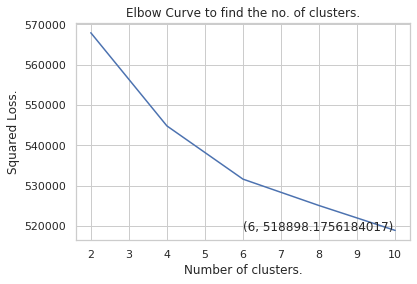

The optimal number of clusters obtained is -  6
The loss for optimal cluster is -  518898.1756184017


In [252]:

def elbow_method(text, num_clus):
    squared_errors = []
    for cluster in num_clus:
        print("Fit %d clusters." %(cluster))
        kmeans = KMeans(n_clusters = cluster).fit(bow) 
        squared_errors.append(kmeans.inertia_)
    
    optimal_clusters = np.argmin(squared_errors) + 2  
    plt.plot(num_clus, squared_errors)
    plt.title("Elbow Curve to find the no. of clusters.")
    plt.xlabel("Number of clusters.")
    plt.ylabel("Squared Loss.")
    xy = (optimal_clusters, min(squared_errors))
    plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
    plt.show()

    print ("The optimal number of clusters obtained is - ", optimal_clusters)
    print ("The loss for optimal cluster is - ", min(squared_errors))
    
    return optimal_clusters
num_clusters = elbow_method(bow, range(2,12,2))

In [253]:
model = KMeans(n_clusters = num_clusters,init='k-means++', n_jobs = -1,random_state=99)
model.fit(bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [254]:
bow_labels = model.labels_
bow_cluster_center=model.cluster_centers_


Koeficijent senke je unutrašnji kriterijum provere našeg klasterovanja. Uzima vrednosti između -1 i 1. Što je bliži koeficijent jedinici, govorimo o jako dobro razdvojenim klasterima i da su naši parametri za klasterovanje prikladni. Negativna vrednost nam govori o mešavini podataka u klasterima.

In [255]:
from sklearn import metrics as met
bow_silhouette_score = met.silhouette_score(bow, bow_labels, metric='euclidean')

In [256]:
bow_silhouette_score

0.0244953197458108

In [257]:
new_df['Bow Cluster Label'] = model.labels_
new_df.head(2)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,company,summary,pros,cons,overall-ratings,CleanedText,Bow Cluster Label
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,positive,peopl smart friend,4
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,positive,cant find compani actual deserv hype get youll...,3


In [258]:
#da vidimo kako su grupisani podaci
new_df.groupby(['Bow Cluster Label'])['pros'].count()

Bow Cluster Label
0     9526
1    12000
2    10084
3     1870
4    14094
5       25
Name: pros, dtype: int64

In [259]:
def top_terms_per_cluster(centers, num_of_clusters, terms, num_of_terms):
    print("Top terms per cluster:")
    order_centroids = centers.argsort()[:, ::-1]
    for i in range(num_of_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :num_of_terms]:
            print(' %s' % terms[ind], end='')
            print()
top_terms_per_cluster(bow_cluster_center, num_clusters, terms, 10)


Top terms per cluster:
Cluster 0: great
 benefit
 peopl
 work
 compani
 pay
 opportun
 good
 lot
 environ
Cluster 1: work
 great
 peopl
 environ
 compani
 place
 lot
 opportun
 cultur
 benefit
Cluster 2: good
 work
 benefit
 pay
 peopl
 compani
 environ
 great
 lot
 salari
Cluster 3: work
 peopl
 compani
 great
 amazon
 get
 team
 lot
 good
 time
Cluster 4: benefit
 peopl
 compani
 lot
 opportun
 learn
 pay
 time
 environ
 get
Cluster 5: amazon
 work
 time
 compani
 manag
 hour
 peopl
 get
 year
 like


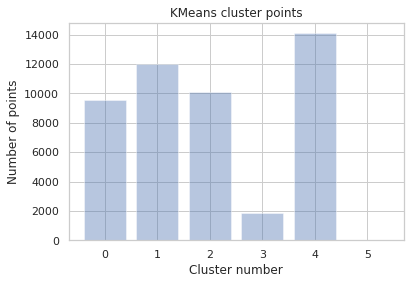

In [260]:
import matplotlib.pyplot as plt
def plot_cluster_points(cluster_label_str, feature, num_clusters):
    plt.bar([x for x in range(num_clusters)], new_df.groupby([cluster_label_str])[feature].count(), alpha = 0.4)
    plt.title('KMeans cluster points')
    plt.xlabel("Cluster number")
    plt.ylabel("Number of points")
    plt.show()

plot_cluster_points('Bow Cluster Label', 'pros', num_clusters)

In [306]:
def print_review_asigned_to_cluster(cluster_label_str, feature, num_clusters):
    for i in range(num_clusters):
        print("review of assigned to cluster ", i)
        print("-" * 70)
        print(new_df.iloc[new_df.groupby([cluster_label_str]).groups[i][0]][feature])
        print('\n')
        print(new_df.iloc[new_df.groupby([cluster_label_str]).groups[i][5]][feature])
        print('\n')
        print(new_df.iloc[new_df.groupby([cluster_label_str]).groups[i][10]][feature])
        print('\n')
        print(new_df.iloc[new_df.groupby([cluster_label_str]).groups[i][20]][feature])
        print("_" * 70)
    
print_review_asigned_to_cluster('Bow Cluster Label', 'pros', num_clusters)

review of assigned to cluster  0
----------------------------------------------------------------------
* Smart people * World class infrastructure * Diverse selection of projects and teams


Employees, food, benefits, perks, shuttle, basically an all-expenses-paid college.


- Great Food - Mentor and Feedback


very good experience, colleagues are smart
______________________________________________________________________
review of assigned to cluster  1
----------------------------------------------------------------------
Great products. Vision you can feel good about. Fair compensation. Automonomy in your role. Wide array of industries / roles employees are able to explore. Feedback loops give employees that ability to provide feedback to management regularly on their performance. Expectation that you will go above and beyond the minimum scope of your role - those that do, are typically rewarded. What more do you want from an employer.


Very inspiring engineers to work with.


Ne

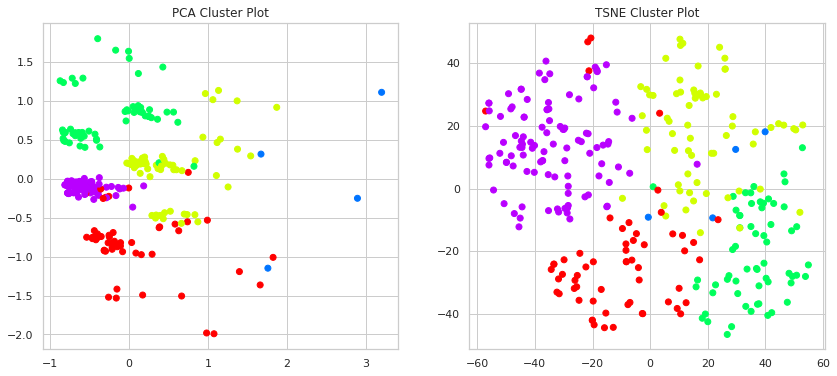

In [262]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(bow, bow_labels)

Klasteri 1, 2 i 4 imaju najviše grupisanih recenzija. Da vidimo šta je najčešće:

In [315]:
print("Cluster 1: ")
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[1][2]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[1][12]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[1][22]]['pros'])
print("\nCluster 2: ")
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[2][2]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[2][12]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[2][22]]['pros'])
print("\nCluster 4: ")
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[4][2]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[4][12]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[4][22]]['pros'])

Cluster 1: 
The people are great to work with
______________________________________________________________________
comfortable environment, free food, nice people
______________________________________________________________________
Great perks such as gym bikes and food

Cluster 2: 
Nice perks. Good work life balance
______________________________________________________________________
Have been at Google almost 2 years. Google is like heaven for a software engineer. I love contributing to the amazing products and learning from the best in the business. My coworkers are very supportive and positive, and manager really cares about me and my goals.
______________________________________________________________________
Scale, values, ambitions. The company continues to be a strong innovator and technical leader.

Cluster 4: 
* There is endless opportunity * You'll never stop learning * I haven't thought about money since I joined.
_____________________________________________________

Klaster 5 ima najmanje recenzija. Da ispišemo sve, kad ih je toliko malo:

In [322]:
print("Cluster 5: ")
print("_" * 70)
for i in range(0, 25, 1):
    print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[5][i]]['pros'])
    print("_" * 70)


Cluster 5: 
______________________________________________________________________
Great working environment. Good work life balance
______________________________________________________________________
casual, high standards, good co workers
______________________________________________________________________
The 10hr shifts go by fast if you stay positive and don’t watch the clock, if your a picker.
______________________________________________________________________
Amazon is always inventing, always looking for new ways to remove waste from a service, or industry. You can change entire careers without finding a new employer.
______________________________________________________________________
Pay is good and cost of living is lower than the bay area
______________________________________________________________________
-Dynamic Environment -Team Oriented. -Great Training. -Incredible managers and peers.
______________________________________________________________________
T

### TF-IDF 

*TF-IDF* (*eng. Term frequency-inverse document frequency*) je još jedan od načina za prevođenje niski u brojeve. Ocena reči se izračunava proizvodom učestalosti zadate reči i 
inverznom ferkvencijom(*"što je učestalija u ostalim tekstovima, ocena će biti manja"*).


In [263]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(new_df['CleanedText'].values)
tfidf.shape



(47599, 10180)

Fit 2 clusters.
Fit 4 clusters.
Fit 6 clusters.
Fit 8 clusters.
Fit 10 clusters.


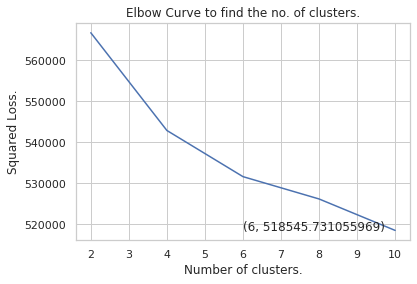

The optimal number of clusters obtained is -  6
The loss for optimal cluster is -  518545.731055969


In [264]:
num_clusters = elbow_method(tfidf, range(2,12,2))

In [265]:
model_tf = KMeans(n_clusters = num_clusters)
model_tf.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [266]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [267]:
terms1 = tfidf_vect.get_feature_names()
terms1[:10]

['aa',
 'aaa',
 'aaaaaamaz',
 'aan',
 'aand',
 'aandacht',
 'aandelen',
 'aapl',
 'aar',
 'ab']

In [268]:
silhouette_score_tf = met.silhouette_score(tfidf, labels_tf, metric='euclidean')
silhouette_score_tf

0.009020989957536007

In [269]:
# Giving Labels/assigning a cluster to each point/text 
tfidf_df = new_df
tfidf_df['Tfidf Cluster Label'] = model_tf.labels_
tfidf_df.head(5)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,company,summary,pros,cons,overall-ratings,CleanedText,Bow Cluster Label,Tfidf Cluster Label
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,positive,peopl smart friend,4,4
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,positive,cant find compani actual deserv hype get youll...,3,4
4,google,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",positive,googl world everi compani lot peopl serious ga...,5,4
5,google,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,positive,peopl busi nice help make suitabl intern proje...,4,4
6,google,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,positive,great work environ good work life balanc,1,0


In [270]:
tfidf_df.groupby(['Tfidf Cluster Label'])['pros'].count()

Tfidf Cluster Label
0     1659
1     3801
2     5152
3     4530
4    27309
5     5148
Name: pros, dtype: int64

In [271]:
top_terms_per_cluster(cluster_center_tf, num_clusters, terms1, 10)


Top terms per cluster:
Cluster 0: balanc
 life
 work
 good
 great
 benefit
 cultur
 peopl
 environ
 flexibl
Cluster 1: pay
 benefit
 good
 great
 decent
 work
 hour
 time
 peopl
 job
Cluster 2: good
 work
 benefit
 environ
 salari
 compani
 peopl
 cultur
 place
 great
Cluster 3: lot
 learn
 opportun
 work
 great
 peopl
 good
 new
 smart
 compani
Cluster 4: work
 peopl
 compani
 benefit
 great
 environ
 best
 cultur
 opportun
 get
Cluster 5: great
 work
 benefit
 peopl
 compani
 environ
 place
 cultur
 opportun
 team


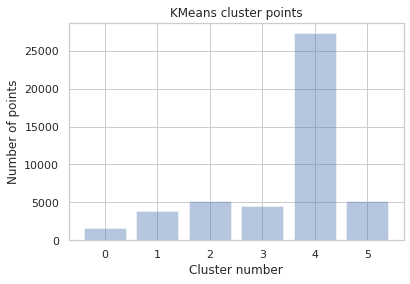

In [272]:
plot_cluster_points('Tfidf Cluster Label', 'pros', num_clusters)

In [273]:
print_review_asigned_to_cluster('Tfidf Cluster Label', 'pros', num_clusters)

A review of assigned to cluster  0
----------------------------------------------------------------------
Great products. Vision you can feel good about. Fair compensation. Automonomy in your role. Wide array of industries / roles employees are able to explore. Feedback loops give employees that ability to provide feedback to management regularly on their performance. Expectation that you will go above and beyond the minimum scope of your role - those that do, are typically rewarded. What more do you want from an employer.


Google’s perks are great: free food, shuttle to work, stock options, fun offices and amenities. The company is also full of really smart people that I’m constantly learning from.


The best company I've worked for. Culture, perks, the way people are treated. Very thankful for this experience.


Great company with creative ideas.
______________________________________________________________________
A review of assigned to cluster  1
--------------------------------

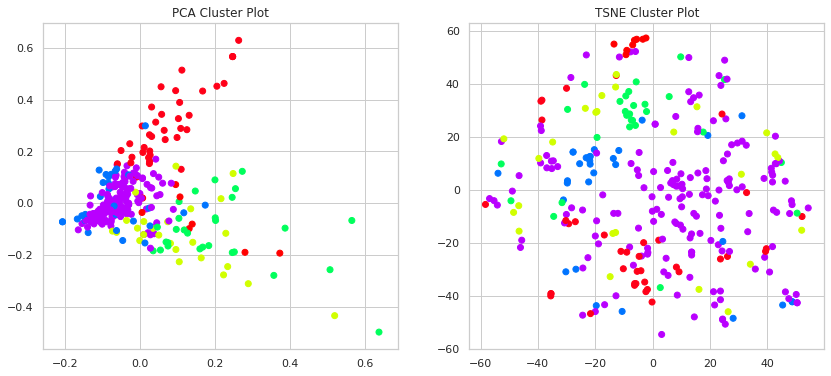

In [274]:
plot_tsne_pca(tfidf, labels_tf)

Klasteri 2, 4 i 5 imaju najviše recenzija. Vidimo da se u 5 pojavljuju i o malo "negativnijim" stranama posla, kao što su smene od 10 sati.

In [324]:
print("Cluster 2: ")
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[2][2]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[2][12]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[2][22]]['pros'])
print("\nCluster 4: ")
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[4][2]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[4][12]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[4][22]]['pros'])
print("\nCluster 5: ")
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[5][2]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[5][12]]['pros'])
print("_" * 70)
print(new_df.iloc[new_df.groupby(['Bow Cluster Label']).groups[5][22]]['pros'])

Cluster 2: 
Nice perks. Good work life balance
______________________________________________________________________
Have been at Google almost 2 years. Google is like heaven for a software engineer. I love contributing to the amazing products and learning from the best in the business. My coworkers are very supportive and positive, and manager really cares about me and my goals.
______________________________________________________________________
Scale, values, ambitions. The company continues to be a strong innovator and technical leader.

Cluster 4: 
* There is endless opportunity * You'll never stop learning * I haven't thought about money since I joined.
______________________________________________________________________
Easy place and people are nice
______________________________________________________________________
free food and good pay

Cluster 5: 
The 10hr shifts go by fast if you stay positive and don’t watch the clock, if your a picker.
___________________________

### *Word2Vec*
<hr />

*Reč u vektor* (*eng. Word2Vec*) je još jedan poznat algoritam da pretvorimo reči u brojeve(*eng. - word embedings*). Svaka reč dobije određen niz brojeva(rezultat pretvaranja je ogromna "matrica"), i pošto imamo nizove brojeva, moći ćemo rastojanjem izmedju vektora da utvrdimo sličnost između reči. 


In [304]:
i=0
list_of_sent=[]
for sent in new_df['CleanedText'].values:
    list_of_sent.append(sent.split())

#list_of_sent[:10]

In [303]:
i=0
list_of_sent_train=[]
for sent in new_df['CleanedText'].values:
    filtered_sentence=[]
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
#list_of_sent_train[:10]

In [277]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent_train,size=100, workers=4)


In [278]:
sent_vectors = []; 
for sent in list_of_sent_train: 
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(47599, 100)

Fit 2 clusters.
Fit 4 clusters.
Fit 6 clusters.
Fit 8 clusters.
Fit 10 clusters.


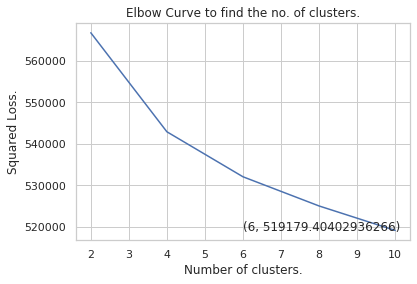

The optimal number of clusters obtained is -  6
The loss for optimal cluster is -  519179.40402936266


In [279]:
num_clusters = elbow_method(sent_vectors, range(2,12,2))

In [280]:
model_w2v = KMeans(n_clusters = num_clusters)
model_w2v.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [281]:
word_cluster_pred=model_w2v.predict(sent_vectors)
word_cluster_pred_2=model_w2v.labels_
word_cluster_center=model_w2v.cluster_centers_


In [282]:
silhouette_score_tf = met.silhouette_score(sent_vectors, word_cluster_pred_2, metric='euclidean')
silhouette_score_tf

0.10463852943277908

In [283]:
df_w2v = tfidf_df
df_w2v['AVG-W2V Cluster Label'] = model_w2v.labels_
df_w2v.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,company,summary,pros,cons,overall-ratings,CleanedText,Bow Cluster Label,Tfidf Cluster Label,AVG-W2V Cluster Label
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,positive,peopl smart friend,4,4,2
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,positive,cant find compani actual deserv hype get youll...,3,4,1
4,google,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",positive,googl world everi compani lot peopl serious ga...,5,4,1
5,google,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,positive,peopl busi nice help make suitabl intern proje...,4,4,3
6,google,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,positive,great work environ good work life balanc,1,0,2


In [284]:
# How many points belong to each cluster ->
df_w2v.groupby(['AVG-W2V Cluster Label'])['pros'].count()

AVG-W2V Cluster Label
0     4756
1    12372
2    10791
3     7358
4     6043
5     6279
Name: pros, dtype: int64

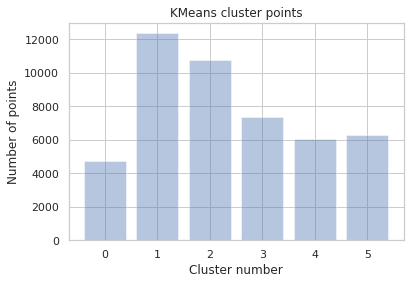

In [285]:
plot_cluster_points('AVG-W2V Cluster Label', 'pros', num_clusters)

In [307]:
print_review_asigned_to_cluster('AVG-W2V Cluster Label', 'pros', num_clusters)

review of assigned to cluster  0
----------------------------------------------------------------------
The food is pretty good


Very friendly work environment. I was certainly treated well by all other employees.


Lots of Good food, some good perks


Great company with amazing perks
______________________________________________________________________
review of assigned to cluster  1
----------------------------------------------------------------------
People are not that busy, so they are nice to help our. They did make a suitable intern project that you can finish it in time and learn something.


The people are great to work with


Good opportunities for different technical experiences, good work-life balance, good compensation, great coworkers


Smart people, great environment
______________________________________________________________________
review of assigned to cluster  2
----------------------------------------------------------------------
People are smart and friendl

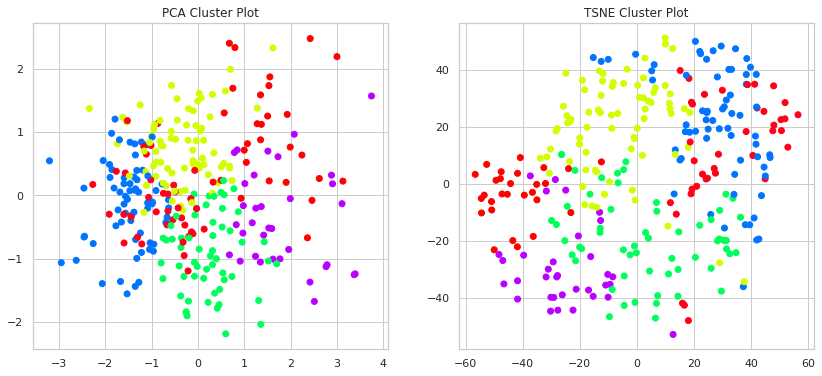

In [287]:
#ne znam koliko je ispravno ovo
import scipy
csr_sent_vectors = scipy.sparse.csr_matrix(sent_vectors)
plot_tsne_pca(csr_sent_vectors, word_cluster_pred_2)

## Klasterovanje putem DBSCAN
<hr />


In [288]:
dbscan_df = df_w2v.head(10000)
dbscan_df.head()


,company,summary,pros,cons,overall-ratings,CleanedText,Bow Cluster Label,Tfidf Cluster Label,AVG-W2V Cluster Label
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,positive,peopl smart friend,4,4,2
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,positive,cant find compani actual deserv hype get youll...,3,4,1
4,google,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",positive,googl world everi compani lot peopl serious ga...,5,4,1
5,google,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,positive,peopl busi nice help make suitabl intern proje...,4,4,3
6,google,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,positive,great work environ good work life balanc,1,0,2


In [289]:
#print(dbscan_df.shape)
i=0
list_of_sent=[]
for sent in dbscan_df['CleanedText'].values:
    list_of_sent.append(sent.split())

    
#list_of_sent[:10]

In [290]:
i=0
list_of_sent_train=[]
for sent in dbscan_df['CleanedText'].values:
    filtered_sentence=[]
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
#list_of_sent_train[:10]

In [291]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,size=100, workers=4)

In [292]:
db_sent_vectors = []; 
for sent in list_of_sent_train: 
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    db_sent_vectors.append(sent_vec)
db_sent_vectors = np.array(db_sent_vectors)
db_sent_vectors = np.nan_to_num(db_sent_vectors)
db_sent_vectors.shape

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(10000, 100)

In [293]:
from sklearn.cluster import DBSCAN


dbscan_model = DBSCAN(eps = 0.8, min_samples = 2, n_jobs=-1, metric='euclidean')
dbscan_model.fit(db_sent_vectors)


DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=-1, p=None)

In [294]:
dbscan_df['AVG-W2V DBSCAN Cluster Label'] = dbscan_model.labels_
dbscan_df.head(2)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,company,summary,pros,cons,overall-ratings,CleanedText,Bow Cluster Label,Tfidf Cluster Label,AVG-W2V Cluster Label,AVG-W2V DBSCAN Cluster Label
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,positive,peopl smart friend,4,4,2,0
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,positive,cant find compani actual deserv hype get youll...,3,4,1,0


In [295]:
db_word_cluster_pred_2=dbscan_model.labels_

dbscan_df.groupby(['AVG-W2V DBSCAN Cluster Label'])['pros'].count()

AVG-W2V DBSCAN Cluster Label
0    10000
Name: pros, dtype: int64

Već za $eps=0.8$, DBSCAN algoritam sve tačke grupiše u jedan klaster. Tako da ovde ne možemo izvući nikakve interesnatne teme vezane za naše recenzije.

## Hiearhijsko klasterovanje

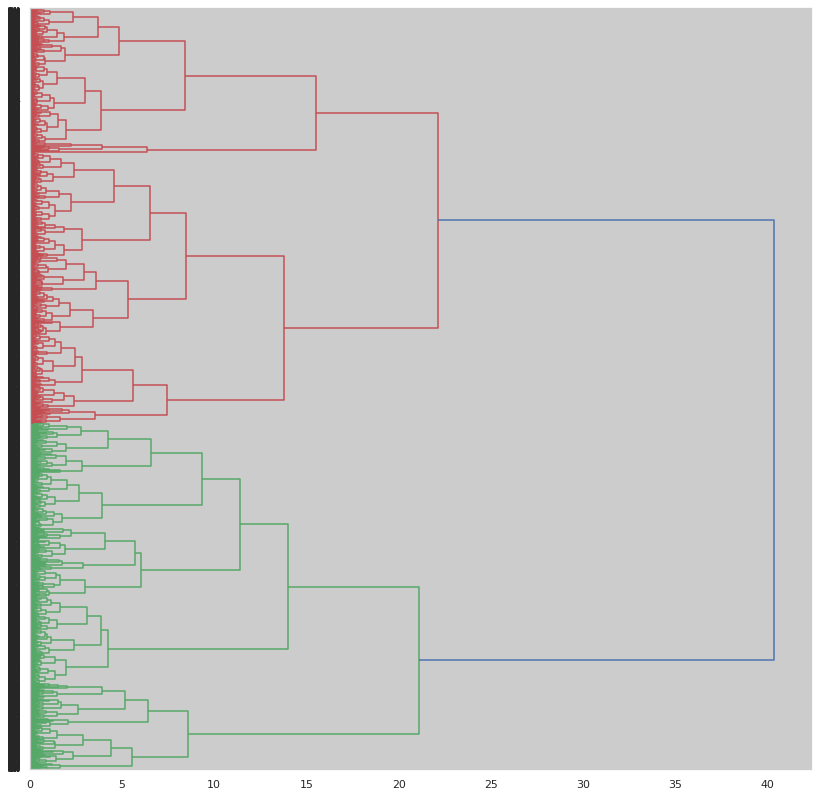

In [296]:
from scipy.cluster import hierarchy
plt.figure(figsize=(14,14))
dendro=hierarchy.dendrogram(hierarchy.linkage(db_sent_vectors,method='ward'), orientation="right")
plt.show()

In [297]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
agg=cluster.fit_predict(db_sent_vectors)

In [298]:
agg_df = dbscan_df
agg_df['AVG-W2V AGG Cluster Label'] = cluster.labels_
agg_df.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,company,summary,pros,cons,overall-ratings,CleanedText,Bow Cluster Label,Tfidf Cluster Label,AVG-W2V Cluster Label,AVG-W2V DBSCAN Cluster Label,AVG-W2V AGG Cluster Label
0,google,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,positive,peopl smart friend,4,4,2,0,0
3,google,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,positive,cant find compani actual deserv hype get youll...,3,4,1,0,0
4,google,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",positive,googl world everi compani lot peopl serious ga...,5,4,1,0,0
5,google,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,positive,peopl busi nice help make suitabl intern proje...,4,4,3,0,0
6,google,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,positive,great work environ good work life balanc,1,0,2,0,1


In [299]:
silhouette_score_agg = met.silhouette_score(db_sent_vectors, cluster.labels_, metric='euclidean')
silhouette_score_agg

0.2879121768664256

In [300]:
agg_df.groupby(['AVG-W2V AGG Cluster Label'])['pros'].count()

AVG-W2V AGG Cluster Label
0    5444
1    4556
Name: pros, dtype: int64

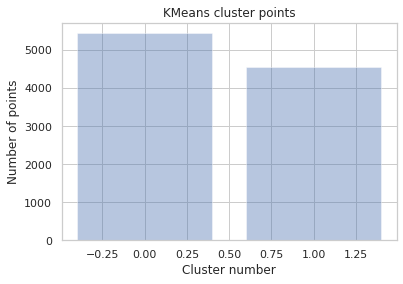

In [301]:
plt.bar([x for x in range(2)], agg_df.groupby(['AVG-W2V AGG Cluster Label'])['pros'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [308]:
for i in range(2):
    print("reviews of assigned to cluster ", i)
    print("-" * 70)
    print(agg_df.iloc[agg_df.groupby(['AVG-W2V AGG Cluster Label']).groups[i][0]]['pros'])
    print('\n')
    print(agg_df.iloc[agg_df.groupby(['AVG-W2V AGG Cluster Label']).groups[i][5]]['pros'])
    print('\n')
    print(agg_df.iloc[agg_df.groupby(['AVG-W2V AGG Cluster Label']).groups[i][10]]['pros'])
    print('\n')
    print(agg_df.iloc[agg_df.groupby(['AVG-W2V AGG Cluster Label']).groups[i][20]]['pros'])

    print("_" * 70)

reviews of assigned to cluster  0
----------------------------------------------------------------------
People are smart and friendly


* There is endless opportunity * You'll never stop learning * I haven't thought about money since I joined.


The people are great to work with, good perks.


Better than average engineers. Competitive compensation.
______________________________________________________________________
reviews of assigned to cluster  1
----------------------------------------------------------------------
Great products. Vision you can feel good about. Fair compensation. Automonomy in your role. Wide array of industries / roles employees are able to explore. Feedback loops give employees that ability to provide feedback to management regularly on their performance. Expectation that you will go above and beyond the minimum scope of your role - those that do, are typically rewarded. What more do you want from an employer.


I love Google a lot


Nice perks. Good work li

# Finalni zaključak

"Lakat" metoda je za K-sredina algoritam pokazala da je optimalan broj klastera 6, dok koeficijent senke za sva tri slučaja korišćenja algoritma ne prelazi *0.1*. 
U slučaju *tf-idf-a*, najveći broj recenzija je grupisao za jedan klaster(*Cluster 4: 27304*), verovatno zbog toga što su reči postale jako učestale u skupu tekstova(pošto smo radili sa kolonom *'pros'*, verovatno su se reči kao što su 'posao', 'benefit', 'zabava', 'hrana' dosta pojavljivale)
U slučaju *bow-a*, zabeležen je najmanji broj recenzija(*Cluster 5: 25*), dok su ostale recenzije raspodeljene jednako.
U slučaju *word2vec-a*, se trudi da raspodeli recenzije ravnomerno po klasterima, i za zadate parametre klasterovanja daje najbolji koeficijent senke za K-sredina klasterovanje.


Zbog bržeg izvršavanja, za *DBSCAN* i Hierarhijsko smo uzeli samo 10000 podataka iz čitavog skupa.
DBSCAN je jako loše odradio svoj posao na skupu od 10000 podataka, grupisajući sve recenzije u jedan klaster(verovatno bi mogla bolja raspodela da se postigne smanjivanjem eps, jer je za 0.2 delio recenzije na dva klastera(doduše Klaster 1 je imao 12 recenzija samo.)).
Za hierarhijsko klasterovanje smo koristili *avg word2vec* metodu, zato što raspodeljuje klastere jednako, i imala je najveću ocenu senke(približno 0.3).

# Literatura <a class="anchor" id="lit"></a>
<hr />

Literatura i kodovi koji su mi pomogli za projekat se mogu naći na ovim linkovima:
 - <a href="https://github.com/avourakis/Employee-Reviews-Analysis">eda i preprocesiranje skupa podataka</a>
 - <a href="https://www.kaggle.com/karthik3890/text-clustering">klasterovanje</a>
 - <a href="https://www.youtube.com/watch?v=FrmrHyOSyhE">countvectorizer</a>
 - <a href="https://www.youtube.com/watch?v=hXNbFNCgPfY">tfidf</a>
 - <a href="https://www.youtube.com/watch?v=LSS_bos_TPI">word2vec</a>
 - <a href="https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469">word2vec</a>
 - slajdovi i kodovi sa predavanja i vežbi